In [1]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from kalman_filter_process import f_x, y_x
import numpy as np
import pandas as pd
import pylab

### Functions $f(x)$ and $y(x)$ from the paper

In [24]:
def f_x(state, dt):
    # constant for sampling time
    h = 2
    
    I_eff = state[0]
    G_s = state[1]
    R_a = state[2]
    R_a_neg_1 = state[3]
    p_1 = state[4]
    p_2 = state[5]
    p_4 = state[6]
    tau = state[7]

    # other required variables not part of the state
    w_k = np.random.normal(1)

    I_p = 0 + w_k
    C = 0 + w_k
    p_3 = 0 + w_k
    V = 0 + w_k # todo check for nonzero for V and value as 140

    # compute I_eff(k+1)
    component_1 = h * (p_2 * (I_eff/(h * p_2) - I_eff))
    component_2 = p_3 * I_p
    I_eff_next = component_1 + component_2

    # compute R_a(k+1)
    a = np.exp((h/tau))
    component_1 = (h * C) / (V * a * tau)
    component_2 = (2 * R_a) / a
    component_3 = R_a_neg_1 / a ** 2
    R_a_next = component_1 + component_2 - component_3

    # assuming G_b to be static for now have asked the prof whether this is fine.
    # todo otherwise the transition function will be time-dependent and that's way harder to implement.
    G_b = 100

    # computing G_s(k+1)
    component_1 = p_1 * (G_b + (G_s / (h * p_1)) - G_s)
    component_2 = p_2 * I_eff * G_s
    component_3 = R_a
    G_s_next = h * (component_1 - component_2 + component_3)

    # remaining variables for the next state
    R_a_neg_1_next = R_a
    p_1_next = p_1
    p_2_next = p_2
    p_4_next = p_4
    tau_next = tau

    next_state = [
        I_eff_next,
        G_s_next,
        R_a_next,
        R_a_neg_1_next,
        p_1_next,
        p_2_next,
        p_4_next,
        tau_next
    ]
    return next_state


def y_x(state):
    # the observation function takes the state and returns the CGM value only because that's what we
    # actually measure
    G_s = state[1]
    return np.array([G_s])

### Read in the meal data

In [25]:
cgm_to_meal = pd.read_csv('data/cgm_to_meal.csv')
cgm_to_meal = cgm_to_meal.dropna()
cgm = cgm_to_meal['cgm'].to_numpy()

### Get the training points

In [31]:
TRAIN_POINTS = 500
START_INDEX = 0
train = cgm[START_INDEX:START_INDEX + TRAIN_POINTS]

### Prepare Kalman Filter inputs

In [32]:
dt = 0.1 # time between samples
points = MerweScaledSigmaPoints(8, alpha=1, beta=2, kappa=0) # sigma points
kf = UnscentedKalmanFilter(dim_x=8, dim_z=1, dt=dt, fx=f_x, hx=y_x, points=points)

# remaining inputs are taken directly from the paper
kf.x = np.array([0, cgm[0], 0, 0, 0.068, 0.037, 1.3, 20]) 
kf.R = np.array([100])
kf.Q = np.diag([1e-06, 1e-06, 1e-03, 1e-03, 1e-02, 1e-01, 1e-02, 1e-01])

### Run the kalman filter predict and update loop, and output predictions at every step

In [33]:
compare = []
for y in train[1:]:
    kf.predict()
    compare.append((kf.x[1], y))
    print(kf.x[2])
    kf.update(y)
compare = np.array(compare)

0.09066873086478172
0.27612721297500437
0.5077853622692268
0.7796454514286655
1.0796767549585196
1.4045893970635595
1.7504044312882088
2.1166307656892864
2.4857646619260305
2.8520675460700557
3.2181181066575757
3.5766367366245766
3.9286529551193095
4.266162218459346
4.598013762255557
4.918069331668661
5.226120199983706
5.52108133235206
5.805388582122513
6.0754285493076114
6.331409016243615
6.572291226177224
6.799433404892132
7.013486725827494
7.215232282015086
7.404971608804064
7.583158289589138
7.750274070297662
7.906809490149542
8.053267930659919
8.190153115730437
8.317964194950163
8.437191850691892
8.548315970405662
8.651801732869554
8.748102842104215
8.837655817097284
8.920883647185274
8.998186128620207
9.069940235257357
9.136508168692208
9.198230834374236
9.255434325301097
9.308425770378527
9.357495855861277
9.402917211436508
9.444945298590824
9.48381893192521
9.51976240600759
9.55298480010058
9.583681288378534
9.612033729133602
9.638211614466105
9.662372752475418
9.68466426568709

### Predicted CGM vs measured CGM values

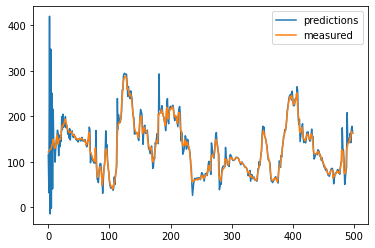

In [29]:
predictions = compare[:, 0]
measured = compare[:, 1]
pylab.plot(predictions, label='predictions')
pylab.plot(measured, label='measured')
pylab.legend()